# **MODE 3 ( RGB & aeosol)**

C:\Users\houss\AppData\Local\Temp\ipykernel_15572\3588139205.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_3 = torch.load(model_path_3, map_location="cpu")


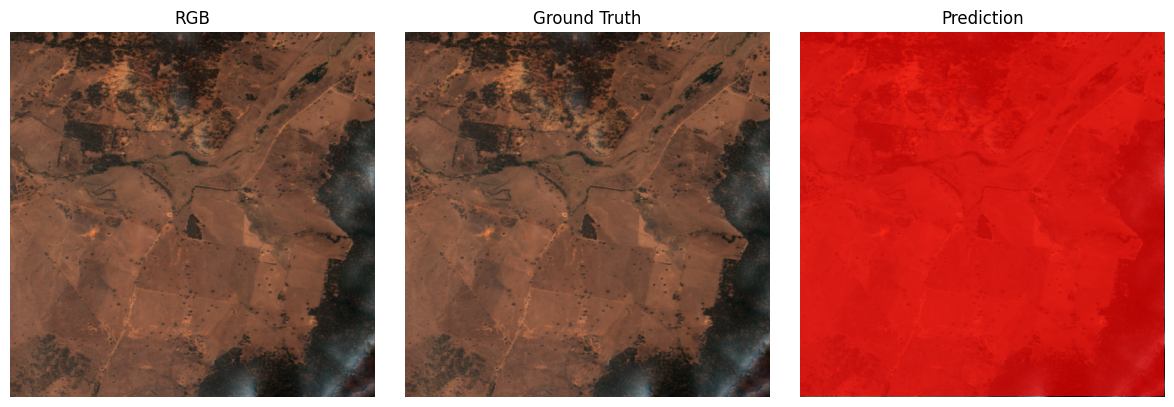

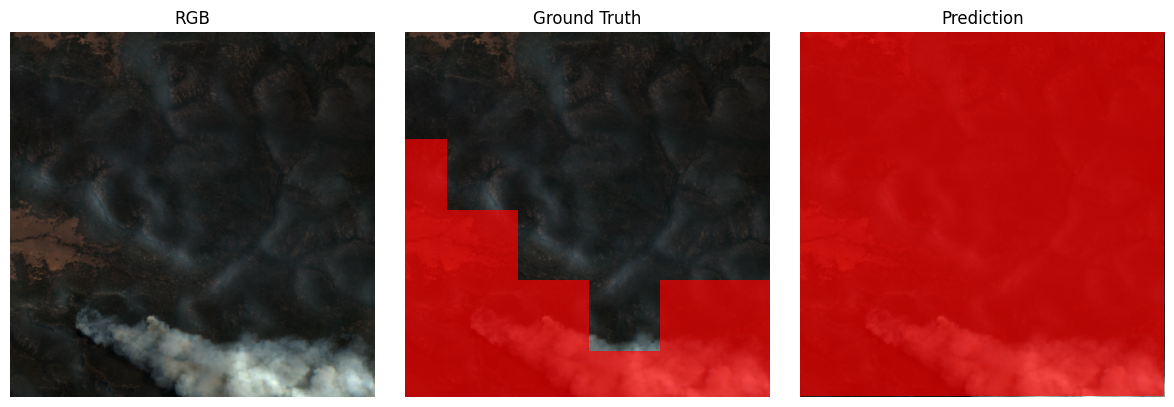

In [4]:
# ========= MODE 3 VIS NOTEBOOK (RGB + aerosol) =========

import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ---------------- paths & imports ----------------
project_root = r"C:/Sen2FireProject"
baseline_code = os.path.join(project_root, "Baseline_code")
sys.path.append(baseline_code)

from model.Networks import unet  # now import works

# ---------------- load mode-3 model ---------------
# mode 3 = rgb_aerosol -> n_channels = 4
model_path_3 = r"C:/Sen2FireProject/Baseline_code/Exp/input_rgb_aerosol/weight_10_time1209_2320/best_model.pth"

model_3 = unet(n_classes=2, n_channels=4)
state_3 = torch.load(model_path_3, map_location="cpu")
model_3.load_state_dict(state_3, strict=True)
model_3.eval()   # CPU is fine for notebook

# ---------------- helper: show one patch ----------

def show_patch_mode3(model, npz_path):
    """
    Visualize one patch for MODE 3 (RGB + aerosol).
    - model: U-Net with n_channels=4 (trained in mode 3)
    - npz_path: path to scene_4_patch_*.npz
    """
    sample = np.load(npz_path)
    img   = sample["image"]    # shape [12,H,W]
    label = sample["label"]    # shape [H,W]
    aerosol = sample["aerosol"]  # shape [H,W]

    # ---- build 4-channel input: RGB + aerosol ----
    # RGB = bands 3,2,1 in Sentinel-2 convention used in baseline
    rgb = img[[3, 2, 1], :, :]          # [3,H,W]
    aerosol = aerosol[np.newaxis, :, :] # [1,H,W]
    img4 = np.concatenate([rgb, aerosol], axis=0)  # [4,H,W]

    # ---- forward pass ----
    tensor = torch.from_numpy(img4).unsqueeze(0).float()  # [1,4,H,W]
    with torch.no_grad():
        logits = model(tensor)
        pred = logits.softmax(1).argmax(1).squeeze().cpu().numpy()  # [H,W], 0/1

    # ---- normalize RGB to [0,1] for display ----
    rgb_vis = img4[:3, :, :]  # [3,H,W]
    rgb_vis = rgb_vis.astype(np.float32)
    rgb_vis = (rgb_vis - rgb_vis.min()) / (rgb_vis.max() - rgb_vis.min() + 1e-8)
    rgb_vis = rgb_vis.transpose(1, 2, 0)  # [H,W,3]

    # ---- transparent fire overlay (0=non-fire, 1=fire) ----
    cmap = ListedColormap([
        (0, 0, 0, 0.0),    # class 0: fully transparent
        (1, 0, 0, 0.7)     # class 1: red with alpha
    ])

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_vis)
    plt.title("RGB")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_vis)
    plt.imshow(label, cmap=cmap, interpolation="nearest")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(rgb_vis)
    plt.imshow(pred, cmap=cmap, interpolation="nearest")
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---------------- examples ----------------

# choose one non-fire patch and one fire patch (adjust if needed)
patch_nofire = r"C:/Sen2FireProject/Sen2Fire/scene4/scene_4_patch_16_13.npz"
patch_fire   = r"C:/Sen2FireProject/Sen2Fire/scene4/scene_4_patch_13_12.npz"

# show non-fire example
show_patch_mode3(model_3, patch_nofire)

# show fire example
show_patch_mode3(model_3, patch_fire)


## ***MAP RESULTS***

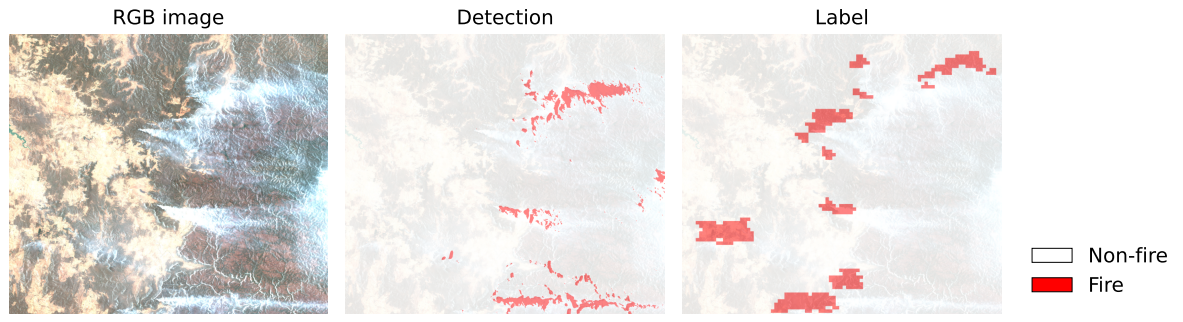

In [2]:
from IPython import display

display.Image("Screenshot 2025-12-20 010046.png")
